<a href="https://colab.research.google.com/github/Sette/fifa-23-sorteio/blob/main/Fifa_23_sorteio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from urllib.request import urlopen,Request
import pandas as pd
from bs4 import BeautifulSoup
import json
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import random
import numpy as np

In [111]:
def get_teams():

  user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
  headers={'User-Agent':user_agent,}

  teams_shape = 100
  


  START_URL = "https://www.fifaindex.com/pt-br/teams"

  request=Request(START_URL,None,headers) #The assembled request
  response = urlopen(request)
  data = response.read() # The data u need

  def quant_pags(START_URL):
    """
        FUNÇÃO QUE PEGA VIA CRAWLER A QUANTIDADE DE PÁGINAS A SEREM EXPLORADAS PELO ALGORITMO
    """
    request=Request(START_URL,None,headers) #The assembled request
    response = urlopen(request)
    html = response.read() # The data u need
    bsObj = BeautifulSoup(html, "html5lib")

    links = bsObj.findAll("a", {"class": "page-link"})

    for link in links:
      if (link.getText()) == "Last":
        print(link.attrs['href'])
        cont = int(link.attrs['href'].split("=")[-1:][0])

    return cont

  def get_teams_from_page_link(link):
    request=Request(link,None,headers) #The assembled request
    response = urlopen(request)
    html = response.read() # The data u need
    bsObj = BeautifulSoup(html, "html5lib")

    


    names = bsObj.findAll("td", {"data-title": "Nome"})
    leagues = bsObj.findAll("a", {"class": "link-league"})
    att	= bsObj.findAll("td", {"data-title": "ATA"})
    mid	= bsObj.findAll("td", {"data-title": "MEI"})
    defense = bsObj.findAll("td", {"data-title": "DEF"})
    over = bsObj.findAll("td", {"data-title": "GER"}) 
    img = bsObj.findAll("img", {"class": "team size-5"}) 


    df = pd.DataFrame({"Name":names,"League":leagues,"Att":att,"Mid":mid,"Def":defense,"Over":over,'Img':img})

    
    

    df["Name"] = df["Name"].apply(lambda x: x.getText())
    df["League"] = df["League"].apply(lambda x: x.getText())
    df["Att"] = df["Att"].apply(lambda x: x.getText())
    df["Mid"] = df["Mid"].apply(lambda x: x.getText())
    df["Def"] = df["Def"].apply(lambda x: x.getText())
    df["Over"] = df["Over"].apply(lambda x: x.getText())
    df["Img"] = df["Img"].apply(lambda x: x['src'])
    
    return df



  pages = quant_pags(START_URL)

  def download_teams(pages):
    return pd.concat([get_teams_from_page_link(f'{START_URL}/?page={page}') for page in  range(1,pages+1)])


  teams = download_teams(pages)

  teams.Att = teams.Att.astype(int)
  teams.Mid = teams.Mid.astype(int)
  teams.Def = teams.Def.astype(int)

  teams = teams.reset_index() 

  teams.drop(columns="index",inplace=True)

  womens_leagues = ["Women's","Féminine"]

  def get_sex_league(team):
    if any(x in team.League for x in womens_leagues):
      return "F"
    
    return "M"

  teams["Sex"] = [get_sex_league(team) for i,team in teams.iterrows()]

  # teams.drop()


  teams = teams[teams['League'] != 'Libertadores']


  teams=teams.head(teams_shape)

  teams_list = [[team[2],team[3],team[4]] for team in teams.values]


  distance_array = pairwise_distances(teams_list, metric='euclidean')

  return teams,distance_array

  


In [112]:
def sorteia(teams,distance_array,threshold = 5):


  sorteios = 10

  def get_team(df,index):
    return df.loc[index]

  def sorteia_peso(teams,distance_array,threshold):
    while True:

      
      rand_idx = random.randrange(distance_array.shape[0])
      rand_idy = random.randrange(distance_array.shape[1])

      random_num = distance_array[rand_idx][rand_idy]
      sorteio = random_num
      
      # 
      if sorteio <= threshold:
        time1,time2 = get_team(teams,rand_idx),get_team(teams,rand_idy)
        time1['Controle'] = 'Controle 1'
        time2['Controle'] = 'Controle 2'
        return [time1,time2]

 
  def sorteia_confronto(teams):
    while True:
      times = sorteia_peso(teams,distance_array,threshold)
      if times[0].Sex == times[1].Sex and times[0].Name != times[1].Name:
        return times

  confrontos = []
  for i in range(sorteios):
    confrontos.append(sorteia_confronto(teams))
  return pd.concat([pd.DataFrame(confronto) for confronto in confrontos])

In [113]:
teams, distance_array  = get_teams()

?page=23


In [117]:
teams.Img.values

array(['https://fifastatic.fifaindex.com/FIFA23/teams/light/10.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/243.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/21.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/73.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/9.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/44.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/240.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/241.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/5.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/18.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/11.png',
       'https://fifastatic.fifaindex.com/FIFA19/images/crest/5/light/45.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/112172.png',
       'https://fifastatic.fifaindex.com/FIFA23/teams/light/22.png',
       'https://fifa

In [119]:
from google.colab.patches import cv2_imshow

In [126]:
!curl -o 1943.png https://fifastatic.fifaindex.com/FIFA23/teams/light/1943.png 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6063  100  6063    0     0   113k      0 --:--:-- --:--:-- --:--:--  113k


In [127]:
import cv2
img = cv2.imread('1943.png', cv2.IMREAD_UNCHANGED)

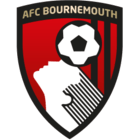

In [128]:
cv2_imshow(img)

In [114]:
sorteia(teams,distance_array,threshold = 2)

/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


KeyError: ignored